# LangGraph Agent Analytics with BigQuery

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/langchain-ai/langchain-google/blob/main/libs/community/examples/bigquery_callback/langgraph_agent_analytics.ipynb">
      <img src="https://raw.githubusercontent.com/googleapis/python-bigquery-dataframes/refs/heads/main/third_party/logo/colab-logo.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/langchain-ai/langchain-google/blob/main/libs/community/examples/bigquery_callback/langgraph_agent_analytics.ipynb">
      <img src="https://raw.githubusercontent.com/googleapis/python-bigquery-dataframes/refs/heads/main/third_party/logo/github-logo.png" width="32" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/langchain-ai/langchain-google/main/libs/community/examples/bigquery_callback/langgraph_agent_analytics.ipynb">
      <img src="https://www.gstatic.com/images/branding/product/1x/google_cloud_48dp.png" alt="Vertex AI logo" width="32">
      Open in Vertex AI Workbench
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/langchain-ai/langchain-google/blob/main/libs/community/examples/bigquery_callback/langgraph_agent_analytics.ipynb">
      <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTW1gvOovVlbZAIZylUtf5Iu8-693qS1w5NJw&s" alt="BQ logo" width="35">
      Open in BQ Studio
    </a>
  </td>
</table>

<br><br><br>

This notebook demonstrates how **BigQuery serves as a unified platform** for LangGraph Agent:
- **Observability** - Real-time event monitoring and tracing
- **Analytics** - Tool usage, latency analysis, and cost tracking
- **Evaluation** - Quality assessment and safety monitoring
- **Memory** - Semantic search across agent conversations

## Architecture

```
┌─────────────────┐     ┌──────────────────────────┐     ┌─────────────────┐
│  LangGraph      │────▶│  BigQueryCallbackHandler │────▶│    BigQuery     │
│  Agent          │     │  (Async Logging)         │     │  agent_events   │
└─────────────────┘     └──────────────────────────┘     └─────────────────┘
                                                                  │
                                                                  ▼
                                                         ┌─────────────────┐
                                                         │  Analytics &    │
                                                         │  Dashboards     │
                                                         └─────────────────┘
```

## Setup & Authentication

In [1]:
# Install required packages (uncomment if needed)
# !pip install google-cloud-bigquery pandas matplotlib seaborn

In [2]:
# Authentication for Google Colab
try:
    from google.colab import auth
    auth.authenticate_user()
    print("Authenticated with Google Colab")
except ImportError:
    print("Not running in Colab - using application default credentials")

Not running in Colab - using application default credentials


In [3]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuration - UPDATE THESE FOR YOUR ENVIRONMENT
PROJECT_ID = "test-project-0728-467323"  # Your GCP project
DATASET_ID = "agent_analytics"           # Your BigQuery dataset
TABLE_ID = "agent_events_v2"             # Your events table

# Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID)
print(f"Connected to BigQuery: {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}")

Connected to BigQuery: test-project-0728-467323.agent_analytics.agent_events_v2


In [4]:
# Helper function to run queries
def run_query(sql: str) -> pd.DataFrame:
    """Execute a BigQuery SQL query and return results as a DataFrame."""
    return client.query(sql).to_dataframe()

# Set display options
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 50)
sns.set_theme(style="whitegrid")

## Table Schema

The `agent_events_v2` table captures all LangGraph agent events with the following schema:

| Column | Type | Description |
|--------|------|-------------|
| `timestamp` | TIMESTAMP | Event timestamp |
| `event_type` | STRING | LLM_REQUEST, LLM_RESPONSE, TOOL_STARTING, TOOL_COMPLETED, NODE_STARTING, GRAPH_START, GRAPH_END, etc. |
| `agent` | STRING | Agent name (e.g., finance_assistant, travel_planner) |
| `session_id` | STRING | Session identifier for conversation tracking |
| `user_id` | STRING | User identifier |
| `trace_id` | STRING | Distributed trace ID |
| `span_id` | STRING | Span ID within trace |
| `content` | JSON | Event content (prompts, responses, tool args/results) |
| `attributes` | JSON | Additional attributes (tool_name, langgraph metadata) |
| `latency_ms` | JSON | Latency measurements |
| `status` | STRING | OK, ERROR |

---
# Phase 1: Real-time Observability

Monitor agent activity in real-time, track events, and understand the flow of requests.

### 1.1 Recent Event Stream

View the most recent agent events across all agents.

In [5]:
recent_events_sql = f"""
SELECT 
    timestamp,
    agent,
    event_type,
    session_id,
    user_id,
    JSON_EXTRACT_SCALAR(attributes, '$.tool_name') as tool_name,
    CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS INT64) as latency_ms,
    status
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE DATE(timestamp) = CURRENT_DATE()
ORDER BY timestamp DESC
LIMIT 30
"""

recent_events = run_query(recent_events_sql)
print(f"Recent {len(recent_events)} events:")
recent_events

Recent 30 events:


,timestamp,agent,event_type,session_id,user_id,tool_name,latency_ms,status
0,2026-01-26 09:16:08.413668+00:00,travel_assistant,GRAPH_END,session-001,user-123,None,4541,OK
1,2026-01-26 09:16:08.413606+00:00,None,GRAPH_END,None,None,None,2952,OK
2,2026-01-26 09:16:08.413181+00:00,None,NODE_COMPLETED,None,None,None,898,OK
3,2026-01-26 09:16:08.413070+00:00,None,NODE_COMPLETED,None,None,None,0,OK
4,2026-01-26 09:16:08.413029+00:00,travel_assistant,NODE_STARTING,session-001,user-123,None,<NA>,OK
5,2026-01-26 09:16:08.412783+00:00,None,NODE_COMPLETED,None,None,None,898,OK
6,2026-01-26 09:16:08.412727+00:00,None,NODE_COMPLETED,None,None,None,897,OK
7,2026-01-26 09:16:08.412623+00:00,None,LLM_RESPONSE,None,None,None,897,OK
8,2026-01-26 09:16:07.515305+00:00,travel_assistant,LLM_REQUEST,session-001,user-123,None,<NA>,OK
9,2026-01-26 09:16:07.514994+00:00,None,NODE_COMPLETED,None,None,None,0,OK


### 1.2 Event Volume by Type

Understand the distribution of event types across your agents.

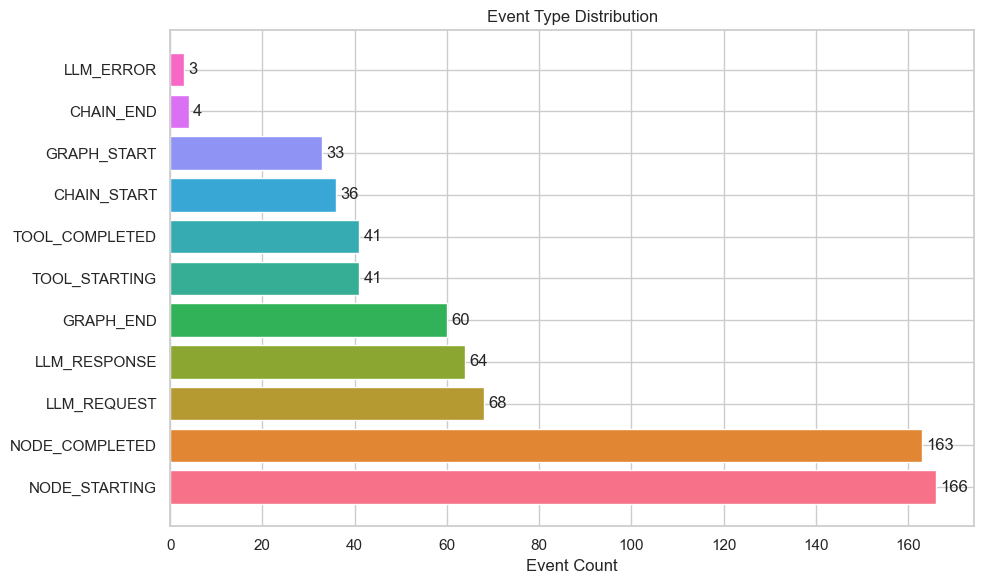

,event_type,count,unique_sessions
0,NODE_STARTING,166,29
1,NODE_COMPLETED,163,0
2,LLM_REQUEST,68,30
3,LLM_RESPONSE,64,0
4,GRAPH_END,60,28
5,TOOL_STARTING,41,26
6,TOOL_COMPLETED,41,0
7,CHAIN_START,36,30
8,GRAPH_START,33,29
9,CHAIN_END,4,0


In [6]:
event_distribution_sql = f"""
SELECT 
    event_type,
    COUNT(*) as count,
    COUNT(DISTINCT session_id) as unique_sessions
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE DATE(timestamp) = CURRENT_DATE()
GROUP BY event_type
ORDER BY count DESC
"""

event_dist = run_query(event_distribution_sql)

# Visualization
if len(event_dist) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = sns.color_palette("husl", len(event_dist))
    bars = ax.barh(event_dist['event_type'], event_dist['count'], color=colors)
    ax.set_xlabel('Event Count')
    ax.set_title('Event Type Distribution')
    ax.bar_label(bars, padding=3)
    plt.tight_layout()
    plt.show()
else:
    print("No event distribution data found for today.")

event_dist

### 1.3 Agent Activity Summary

Compare activity levels across different agents.

In [7]:
agent_activity_sql = f"""
SELECT 
    agent,
    COUNT(*) as total_events,
    COUNT(DISTINCT session_id) as sessions,
    COUNT(DISTINCT user_id) as unique_users,
    COUNTIF(event_type = 'LLM_REQUEST') as llm_calls,
    COUNTIF(event_type = 'TOOL_STARTING') as tool_calls,
    COUNTIF(status = 'ERROR') as errors
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE DATE(timestamp) = CURRENT_DATE()
  AND agent IS NOT NULL
GROUP BY agent
ORDER BY total_events DESC
"""

agent_activity = run_query(agent_activity_sql)
agent_activity

,agent,total_events,sessions,unique_users,llm_calls,tool_calls,errors
0,finance_assistant,90,8,5,16,10,0
1,gemini3_agent,84,5,1,15,12,0
2,travel_planner,57,6,4,10,5,0
3,customer_support,55,5,4,10,5,0
4,travel_assistant,42,1,1,4,6,0
5,langgraph_example,37,4,1,7,3,0
6,basic_example,9,1,1,6,0,0


---
# Phase 2: Performance Analytics

Analyze latency, tool usage patterns, and identify performance bottlenecks.

### 2.1 Tool Usage Analysis

Which tools are being used most frequently and by which agents?

In [8]:
tool_usage_sql = f"""
SELECT 
    agent,
    JSON_EXTRACT_SCALAR(attributes, '$.tool_name') as tool_name,
    COUNT(*) as call_count,
    AVG(CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS FLOAT64)) as avg_latency_ms,
    MAX(CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS FLOAT64)) as max_latency_ms,
    COUNTIF(status = 'ERROR') as error_count
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE event_type = 'TOOL_COMPLETED'
  AND DATE(timestamp) = CURRENT_DATE()
  AND JSON_EXTRACT_SCALAR(attributes, '$.tool_name') IS NOT NULL
GROUP BY agent, tool_name
ORDER BY call_count DESC
"""

tool_usage = run_query(tool_usage_sql)

# Visualization - Tool usage heatmap
if len(tool_usage) > 0 and tool_usage['agent'].notna().any() and tool_usage['tool_name'].notna().any():
    pivot_data = tool_usage.pivot_table(
        index='tool_name', 
        columns='agent', 
        values='call_count', 
        fill_value=0
    )
    
    # Only create heatmap if pivot_data has data
    if pivot_data.size > 0 and not pivot_data.empty:
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.heatmap(pivot_data, annot=True, fmt='g', cmap='YlOrRd', ax=ax)
        ax.set_title('Tool Usage by Agent')
        plt.tight_layout()
        plt.show()
    else:
        print("No tool usage data available for heatmap visualization.")
else:
    print("No tool usage data found for today.")

tool_usage

No tool usage data found for today.


,agent,tool_name,call_count,avg_latency_ms,max_latency_ms,error_count
0,None,get_stock_price,9,0.0,0.0,0
1,None,get_weather,7,0.0,0.0,0
2,None,convert_currency,7,0.0,0.0,0
3,None,calculate,5,0.0,0.0,0
4,None,check_order_status,3,0.0,0.0,0
5,None,calculator,2,0.5,1.0,0
6,None,process_refund,2,0.0,0.0,0
7,None,get_current_time,2,0.0,0.0,0
8,None,search,1,0.0,0.0,0
9,None,get_current_datetime,1,0.0,0.0,0


### 2.2 Latency Analysis

Understand latency distribution across LLM calls and tool executions.

In [9]:
latency_analysis_sql = f"""
SELECT 
    event_type,
    agent,
    COUNT(*) as count,
    ROUND(AVG(CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS FLOAT64)), 2) as avg_latency_ms,
    ROUND(APPROX_QUANTILES(CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS FLOAT64), 100)[OFFSET(50)], 2) as p50_latency_ms,
    ROUND(APPROX_QUANTILES(CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS FLOAT64), 100)[OFFSET(95)], 2) as p95_latency_ms,
    MAX(CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS INT64)) as max_latency_ms
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE DATE(timestamp) = CURRENT_DATE()
  AND event_type IN ('LLM_RESPONSE', 'TOOL_COMPLETED', 'GRAPH_END')
  AND JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') IS NOT NULL
GROUP BY event_type, agent
ORDER BY avg_latency_ms DESC
"""

latency_analysis = run_query(latency_analysis_sql)
latency_analysis

,event_type,agent,count,avg_latency_ms,p50_latency_ms,p95_latency_ms,max_latency_ms
0,GRAPH_END,langgraph_example,3,22566.00,890.0,65923.0,65923
1,GRAPH_END,travel_planner,6,21694.17,6325.0,83045.0,83045
2,GRAPH_END,customer_support,5,19960.20,5156.0,68538.0,68538
3,GRAPH_END,finance_assistant,8,18798.75,14355.0,40661.0,40661
4,GRAPH_END,None,30,17114.33,9801.0,66879.0,81198
5,GRAPH_END,gemini3_agent,6,11668.50,11087.0,17874.0,17874
6,LLM_RESPONSE,None,64,8130.25,2284.0,39340.0,79932
7,GRAPH_END,travel_assistant,2,4340.50,4140.0,4541.0,4541
8,TOOL_COMPLETED,None,41,0.02,0.0,0.0,1


### 2.3 Graph Execution Analysis

Analyze complete graph executions (session-level metrics).

In [10]:
graph_execution_sql = f"""
WITH graph_sessions AS (
    SELECT 
        session_id,
        agent,
        user_id,
        MIN(timestamp) as start_time,
        MAX(timestamp) as end_time,
        COUNTIF(event_type = 'LLM_REQUEST') as llm_calls,
        COUNTIF(event_type = 'TOOL_STARTING') as tool_calls,
        MAX(CASE WHEN event_type = 'GRAPH_END' 
            THEN CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS INT64) END) as total_latency_ms,
        COUNTIF(status = 'ERROR') as errors
    FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
    WHERE DATE(timestamp) = CURRENT_DATE()
    GROUP BY session_id, agent, user_id
)
SELECT 
    session_id,
    agent,
    user_id,
    start_time,
    llm_calls,
    tool_calls,
    total_latency_ms,
    errors,
    CASE WHEN errors > 0 THEN 'Failed' ELSE 'Success' END as status
FROM graph_sessions
ORDER BY start_time DESC
LIMIT 20
"""

graph_execution = run_query(graph_execution_sql)
graph_execution

,session_id,agent,user_id,start_time,llm_calls,tool_calls,total_latency_ms,errors,status
0,session-001,travel_assistant,user-123,2026-01-26 09:15:05.178151+00:00,4,6,4541,0,Success
1,customer_support-eve-1769415929-4,customer_support,eve,2026-01-26 08:25:29.317015+00:00,2,1,2959,0,Success
2,customer_support-charlie-1769415925-3,customer_support,charlie,2026-01-26 08:25:25.176244+00:00,2,1,3135,0,Success
3,customer_support-bob-1769415904-2,customer_support,bob,2026-01-26 08:25:04.157620+00:00,2,1,20013,0,Success
4,customer_support-diana-1769415897-1,customer_support,diana,2026-01-26 08:24:57.997104+00:00,2,1,5156,0,Success
5,customer_support-charlie-1769415828-0,customer_support,charlie,2026-01-26 08:23:50.112491+00:00,2,1,68538,0,Success
6,travel_planner-alice-1769415821-5,travel_planner,alice,2026-01-26 08:23:41.511320+00:00,1,0,4153,0,Success
7,travel_planner-eve-1769415817-4,travel_planner,eve,2026-01-26 08:23:37.357179+00:00,2,1,3153,0,Success
8,travel_planner-bob-1769415806-3,travel_planner,bob,2026-01-26 08:23:26.550088+00:00,2,2,9802,0,Success
9,travel_planner-alice-1769415799-2,travel_planner,alice,2026-01-26 08:23:19.219654+00:00,1,0,6325,0,Success


### 2.4 Cost Estimation

Estimate costs based on token usage (using approximate token counts from content length).

In [11]:
cost_estimation_sql = f"""
WITH token_estimates AS (
    SELECT 
        agent,
        event_type,
        -- Rough estimate: 1 token ≈ 4 characters
        CEIL(LENGTH(TO_JSON_STRING(content)) / 4) as estimated_tokens
    FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
    WHERE DATE(timestamp) = CURRENT_DATE()
      AND event_type IN ('LLM_REQUEST', 'LLM_RESPONSE')
)
SELECT 
    agent,
    SUM(CASE WHEN event_type = 'LLM_REQUEST' THEN estimated_tokens ELSE 0 END) as input_tokens,
    SUM(CASE WHEN event_type = 'LLM_RESPONSE' THEN estimated_tokens ELSE 0 END) as output_tokens,
    SUM(estimated_tokens) as total_tokens,
    -- Gemini 2.5 Flash pricing: $0.30/1M input, $2.50/1M output
    -- See: https://cloud.google.com/vertex-ai/generative-ai/pricing
    ROUND(SUM(CASE WHEN event_type = 'LLM_REQUEST' THEN estimated_tokens ELSE 0 END) * 0.0000003 +
          SUM(CASE WHEN event_type = 'LLM_RESPONSE' THEN estimated_tokens ELSE 0 END) * 0.0000025, 4) as estimated_cost_usd
FROM token_estimates
GROUP BY agent
ORDER BY total_tokens DESC
"""

cost_estimation = run_query(cost_estimation_sql)
cost_estimation

,agent,input_tokens,output_tokens,total_tokens,estimated_cost_usd
0,None,0.0,1003.0,1003.0,0.0025
1,gemini3_agent,539.0,0.0,539.0,0.0002
2,finance_assistant,276.0,0.0,276.0,0.0001
3,travel_planner,236.0,0.0,236.0,0.0001
4,customer_support,219.0,0.0,219.0,0.0001
5,travel_assistant,142.0,0.0,142.0,0.0000
6,basic_example,88.0,0.0,88.0,0.0000
7,langgraph_example,86.0,0.0,86.0,0.0000


---
# Phase 3: Error Analysis & Debugging

Identify and analyze errors to improve agent reliability.

### 3.1 Error Summary

Overview of errors by type and agent.

In [12]:
error_summary_sql = f"""
SELECT 
    agent,
    event_type,
    COUNT(*) as error_count,
    MIN(timestamp) as first_occurrence,
    MAX(timestamp) as last_occurrence
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE status = 'ERROR'
  AND DATE(timestamp) >= DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY)
GROUP BY agent, event_type
ORDER BY error_count DESC
"""

error_summary = run_query(error_summary_sql)
if len(error_summary) > 0:
    print(f"Found {len(error_summary)} error types:")
    display(error_summary)
else:
    print("No errors found in the last 7 days!")

Found 1 error types:


,agent,event_type,error_count,first_occurrence,last_occurrence
0,None,LLM_ERROR,3,2026-01-26 07:59:12.444795+00:00,2026-01-26 08:07:25.193196+00:00


### 3.2 Error Details

Detailed view of recent errors with context.

In [13]:
error_details_sql = f"""
SELECT 
    timestamp,
    agent,
    session_id,
    event_type,
    JSON_EXTRACT_SCALAR(attributes, '$.tool_name') as tool_name,
    SUBSTR(TO_JSON_STRING(content), 1, 200) as content_preview
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE status = 'ERROR'
  AND DATE(timestamp) = CURRENT_DATE()
ORDER BY timestamp DESC
LIMIT 10
"""

error_details = run_query(error_details_sql)
if len(error_details) > 0:
    display(error_details)
else:
    print("No errors today!")

,timestamp,agent,session_id,event_type,tool_name,content_preview
0,2026-01-26 08:07:25.193196+00:00,None,None,LLM_ERROR,None,"{""summary"":""None""}"
1,2026-01-26 08:00:48.158894+00:00,None,None,LLM_ERROR,None,"{""summary"":""None""}"
2,2026-01-26 07:59:12.444795+00:00,None,None,LLM_ERROR,None,"{""summary"":""None""}"


---
# Phase 4: Session & Conversation Analysis

Reconstruct and analyze complete agent conversations.

### 4.1 Session Timeline

View the complete event timeline for a specific session.

In [14]:
# First, get a sample session ID
sample_session_sql = f"""
SELECT DISTINCT session_id
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE DATE(timestamp) = CURRENT_DATE()
  AND session_id IS NOT NULL
ORDER BY session_id DESC
LIMIT 1
"""

sample_session = run_query(sample_session_sql)
if len(sample_session) > 0:
    session_id = sample_session.iloc[0]['session_id']
    print(f"Analyzing session: {session_id}")
else:
    session_id = None
    print("No sessions found")

Analyzing session: travel_planner-eve-1769415817-4


In [15]:
if session_id:
    session_timeline_sql = f"""
    SELECT 
        timestamp,
        event_type,
        JSON_EXTRACT_SCALAR(attributes, '$.tool_name') as tool_name,
        CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS INT64) as latency_ms,
        status,
        SUBSTR(TO_JSON_STRING(content), 1, 200) as content_preview
    FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
    WHERE session_id = '{session_id}'
    ORDER BY timestamp
    """
    
    session_timeline = run_query(session_timeline_sql)
    print(f"Session {session_id} - {len(session_timeline)} events:")
    display(session_timeline)

Session travel_planner-eve-1769415817-4 - 11 events:


,timestamp,event_type,tool_name,latency_ms,status,content_preview
0,2026-01-26 08:23:37.357179+00:00,GRAPH_START,None,<NA>,OK,"{""summary"":""{\""graph_name\"": \""travel_planner\""}""}"
1,2026-01-26 08:23:37.357373+00:00,CHAIN_START,None,<NA>,OK,"{""summary"":""{\""messages\"": [\""content='How much is 2000 USD in EUR for my Europe trip?' addition..."
2,2026-01-26 08:23:37.357864+00:00,NODE_STARTING,None,<NA>,OK,"{""summary"":""{\""messages\"": [\""content='How much is 2000 USD in EUR for my Europe trip?' addition..."
3,2026-01-26 08:23:37.358023+00:00,LLM_REQUEST,None,<NA>,OK,"{""summary"":""How much is 2000 USD in EUR for my Europe trip?""}"
4,2026-01-26 08:23:39.324445+00:00,NODE_STARTING,None,<NA>,OK,"{""summary"":""{\""messages\"": [\""content='How much is 2000 USD in EUR for my Europe trip?' addition..."
5,2026-01-26 08:23:39.324804+00:00,NODE_STARTING,None,<NA>,OK,"{""summary"":""{\""messages\"": [\""content='How much is 2000 USD in EUR for my Europe trip?' addition..."
6,2026-01-26 08:23:39.325539+00:00,TOOL_STARTING,convert_currency,<NA>,OK,"{""summary"":""{'tool': 'convert_currency', 'input': \""{'from_currency': 'USD', 'to_currency': 'EUR..."
7,2026-01-26 08:23:39.326350+00:00,NODE_STARTING,None,<NA>,OK,"{""summary"":""{\""messages\"": [\""content='How much is 2000 USD in EUR for my Europe trip?' addition..."
8,2026-01-26 08:23:39.326500+00:00,LLM_REQUEST,None,<NA>,OK,"{""summary"":""How much is 2000 USD in EUR for my Europe trip? | | 2,000.00 USD = 1,851.85 EUR""}"
9,2026-01-26 08:23:40.510249+00:00,NODE_STARTING,None,<NA>,OK,"{""summary"":""{\""messages\"": [\""content='How much is 2000 USD in EUR for my Europe trip?' addition..."


### 4.2 Conversation Reconstruction

Reconstruct the human-agent conversation from a session.

In [16]:
if session_id:
    conversation_sql = f"""
    SELECT 
        timestamp,
        CASE 
            WHEN event_type = 'LLM_REQUEST' THEN '👤 User'
            WHEN event_type = 'LLM_RESPONSE' THEN '🤖 Agent'
            WHEN event_type = 'TOOL_STARTING' THEN '🔧 Tool Call'
            WHEN event_type = 'TOOL_COMPLETED' THEN '✅ Tool Result'
            ELSE event_type
        END as role,
        JSON_EXTRACT_SCALAR(attributes, '$.tool_name') as tool,
        SUBSTR(JSON_EXTRACT_SCALAR(content, '$.summary'), 1, 300) as message
    FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
    WHERE session_id = '{session_id}'
      AND event_type IN ('LLM_REQUEST', 'LLM_RESPONSE', 'TOOL_STARTING', 'TOOL_COMPLETED')
    ORDER BY timestamp
    """
    
    conversation = run_query(conversation_sql)
    print(f"Conversation for session {session_id}:")
    for _, row in conversation.iterrows():
        tool_info = f" [{row['tool']}]" if pd.notna(row['tool']) else ""
        print(f"{row['role']}{tool_info}: {row['message'] or '(no content)'}")
        print()

Conversation for session travel_planner-eve-1769415817-4:
👤 User: How much is 2000 USD in EUR for my Europe trip?

🔧 Tool Call [convert_currency]: {'tool': 'convert_currency', 'input': "{'from_currency': 'USD', 'to_currency': 'EUR', 'amount': 2000}"}

👤 User: How much is 2000 USD in EUR for my Europe trip? |  | 2,000.00 USD = 1,851.85 EUR



---
# Phase 5: User Analytics

Understand user behavior and engagement patterns.

### 5.1 User Engagement Metrics

In [17]:
user_engagement_sql = f"""
SELECT 
    user_id,
    COUNT(DISTINCT session_id) as total_sessions,
    COUNT(DISTINCT agent) as agents_used,
    COUNTIF(event_type = 'LLM_REQUEST') as total_queries,
    COUNTIF(event_type = 'TOOL_STARTING') as tool_interactions,
    ROUND(AVG(CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS FLOAT64)), 0) as avg_response_time_ms,
    COUNTIF(status = 'ERROR') as errors_encountered
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE DATE(timestamp) = CURRENT_DATE()
  AND user_id IS NOT NULL
GROUP BY user_id
ORDER BY total_sessions DESC
"""

user_engagement = run_query(user_engagement_sql)
user_engagement

,user_id,total_sessions,agents_used,total_queries,tool_interactions,avg_response_time_ms,errors_encountered
0,demo-user,10,3,26,15,15301.0,0
1,diana,5,3,10,5,28515.0,0
2,alice,5,2,8,3,12201.0,0
3,bob,3,3,6,5,23492.0,0
4,eve,3,3,6,3,6822.0,0
5,charlie,3,2,6,4,28611.0,0
6,user-123,1,1,4,6,4341.0,0


### 5.2 Agent Preference by User

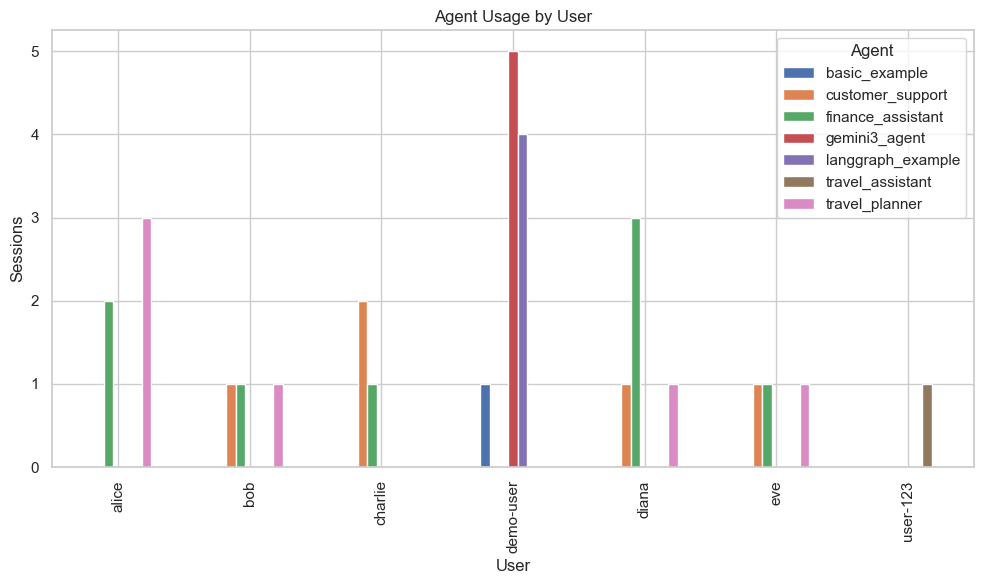

,user_id,agent,sessions,total_events
0,alice,travel_planner,3,23
1,alice,finance_assistant,2,22
2,bob,travel_planner,1,12
3,bob,customer_support,1,11
4,bob,finance_assistant,1,12
5,charlie,customer_support,2,22
6,charlie,finance_assistant,1,12
7,demo-user,gemini3_agent,5,84
8,demo-user,langgraph_example,4,37
9,demo-user,basic_example,1,7


In [18]:
user_agent_preference_sql = f"""
SELECT 
    user_id,
    agent,
    COUNT(DISTINCT session_id) as sessions,
    COUNT(*) as total_events
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE DATE(timestamp) = CURRENT_DATE()
  AND user_id IS NOT NULL
  AND agent IS NOT NULL
GROUP BY user_id, agent
ORDER BY user_id, sessions DESC
"""

user_agent_pref = run_query(user_agent_preference_sql)

if len(user_agent_pref) > 0 and user_agent_pref['user_id'].notna().any() and user_agent_pref['agent'].notna().any():
    pivot = user_agent_pref.pivot_table(
        index='user_id', 
        columns='agent', 
        values='sessions', 
        fill_value=0
    )
    
    if pivot.size > 0 and not pivot.empty:
        fig, ax = plt.subplots(figsize=(10, 6))
        pivot.plot(kind='bar', ax=ax)
        ax.set_title('Agent Usage by User')
        ax.set_xlabel('User')
        ax.set_ylabel('Sessions')
        plt.legend(title='Agent')
        plt.tight_layout()
        plt.show()
    else:
        print("No user-agent preference data available for visualization.")
else:
    print("No user-agent preference data found for today.")

user_agent_pref

---
# Phase 6: Time-Series Analysis

Analyze trends over time.

### 6.1 Hourly Activity Pattern

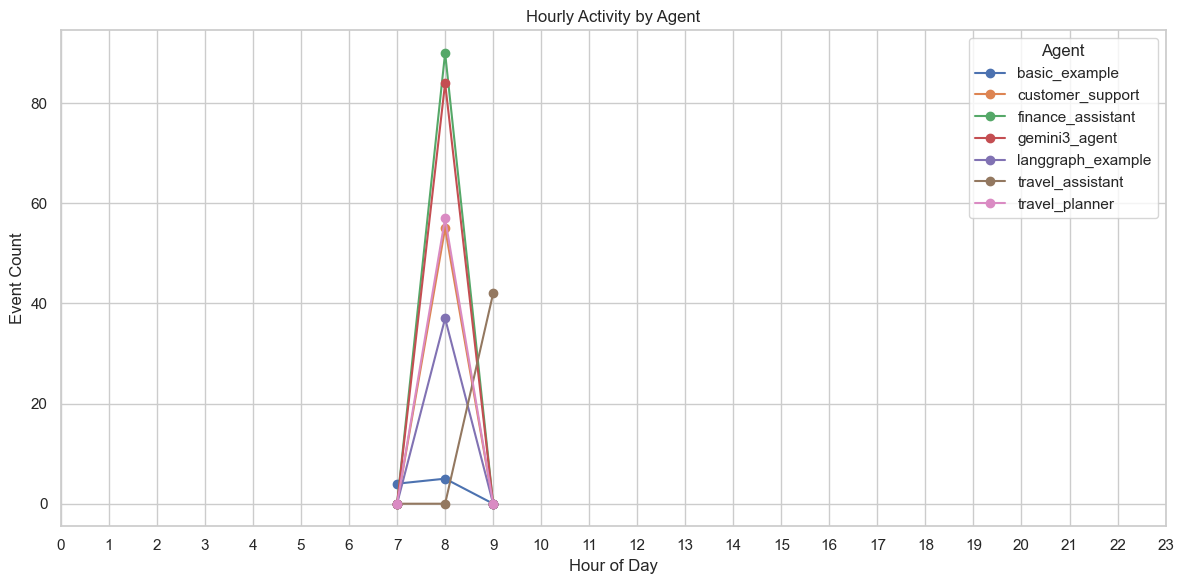

In [19]:
hourly_activity_sql = f"""
SELECT 
    EXTRACT(HOUR FROM timestamp) as hour,
    agent,
    COUNT(*) as event_count
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE DATE(timestamp) = CURRENT_DATE()
  AND agent IS NOT NULL
GROUP BY hour, agent
ORDER BY hour, agent
"""

hourly_activity = run_query(hourly_activity_sql)

if len(hourly_activity) > 0 and hourly_activity['hour'].notna().any() and hourly_activity['agent'].notna().any():
    pivot = hourly_activity.pivot_table(
        index='hour', 
        columns='agent', 
        values='event_count', 
        fill_value=0
    )
    
    if pivot.size > 0 and not pivot.empty:
        fig, ax = plt.subplots(figsize=(12, 6))
        pivot.plot(kind='line', marker='o', ax=ax)
        ax.set_title('Hourly Activity by Agent')
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Event Count')
        ax.set_xticks(range(24))
        plt.legend(title='Agent')
        plt.tight_layout()
        plt.show()
    else:
        print("No hourly activity data available for visualization.")
else:
    print("No hourly activity data found for today.")

### 6.2 Latency Trend

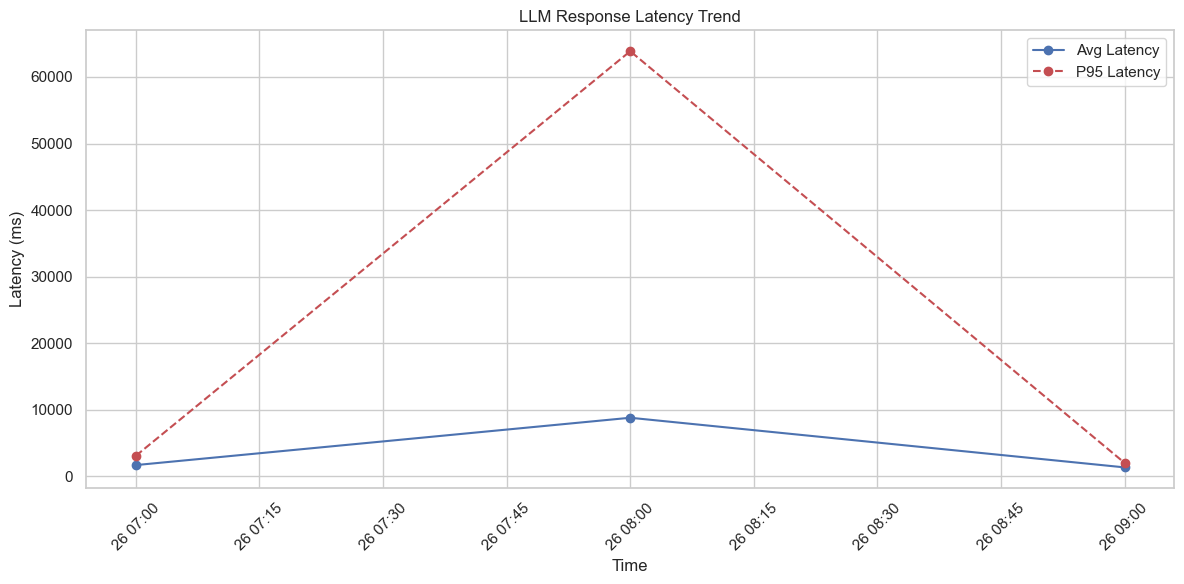

In [20]:
latency_trend_sql = f"""
SELECT 
    TIMESTAMP_TRUNC(timestamp, HOUR) as hour,
    AVG(CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS FLOAT64)) as avg_latency_ms,
    APPROX_QUANTILES(CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS FLOAT64), 100)[OFFSET(95)] as p95_latency_ms
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE DATE(timestamp) = CURRENT_DATE()
  AND event_type = 'LLM_RESPONSE'
  AND JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') IS NOT NULL
GROUP BY hour
ORDER BY hour
"""

latency_trend = run_query(latency_trend_sql)

if len(latency_trend) > 0 and latency_trend['hour'].notna().any():
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(latency_trend['hour'], latency_trend['avg_latency_ms'], 'b-o', label='Avg Latency')
    ax.plot(latency_trend['hour'], latency_trend['p95_latency_ms'], 'r--o', label='P95 Latency')
    ax.set_title('LLM Response Latency Trend')
    ax.set_xlabel('Time')
    ax.set_ylabel('Latency (ms)')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No latency trend data found for today.")

---
# Summary Dashboard

Key metrics at a glance.

In [21]:
summary_sql = f"""
SELECT 
    COUNT(*) as total_events,
    COUNT(DISTINCT session_id) as total_sessions,
    COUNT(DISTINCT user_id) as unique_users,
    COUNT(DISTINCT agent) as active_agents,
    COUNTIF(event_type = 'LLM_REQUEST') as llm_requests,
    COUNTIF(event_type = 'TOOL_STARTING') as tool_invocations,
    COUNTIF(status = 'ERROR') as total_errors,
    ROUND(COUNTIF(status = 'ERROR') * 100.0 / COUNT(*), 2) as error_rate_pct,
    ROUND(AVG(CASE WHEN event_type = 'LLM_RESPONSE' 
        THEN CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS FLOAT64) END), 0) as avg_llm_latency_ms
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE DATE(timestamp) = CURRENT_DATE()
"""

summary = run_query(summary_sql)

print("=" * 60)
print("📊 LangGraph Agent Analytics - Daily Summary")
print("=" * 60)
print(f"\n📈 Volume Metrics:")
print(f"   Total Events:      {summary.iloc[0]['total_events']:,}")
print(f"   Total Sessions:    {summary.iloc[0]['total_sessions']:,}")
print(f"   Unique Users:      {summary.iloc[0]['unique_users']:,}")
print(f"   Active Agents:     {summary.iloc[0]['active_agents']}")
print(f"\n🤖 Agent Activity:")
print(f"   LLM Requests:      {summary.iloc[0]['llm_requests']:,}")
print(f"   Tool Invocations:  {summary.iloc[0]['tool_invocations']:,}")
print(f"\n⚡ Performance:")
print(f"   Avg LLM Latency:   {summary.iloc[0]['avg_llm_latency_ms']:,.0f} ms")
print(f"\n❌ Reliability:")
print(f"   Total Errors:      {summary.iloc[0]['total_errors']:,}")
print(f"   Error Rate:        {summary.iloc[0]['error_rate_pct']:.2f}%")
print("\n" + "=" * 60)

📊 LangGraph Agent Analytics - Daily Summary

📈 Volume Metrics:
   Total Events:      679.0
   Total Sessions:    30.0
   Unique Users:      7.0
   Active Agents:     7.0

🤖 Agent Activity:
   LLM Requests:      68.0
   Tool Invocations:  41.0

⚡ Performance:
   Avg LLM Latency:   8,130 ms

❌ Reliability:
   Total Errors:      3.0
   Error Rate:        0.44%



---
## Next Steps

1. **Set up scheduled queries** to run these analytics automatically
2. **Create Looker dashboards** for real-time monitoring
3. **Configure alerts** for error rate spikes or latency degradation
4. **Enable BQML** for advanced analytics (embeddings, sentiment analysis)

### Useful SQL Patterns

```sql
-- Get conversation context for a session
SELECT * FROM `project.dataset.agent_events_v2`
WHERE session_id = 'your-session-id'
ORDER BY timestamp;

-- Find slow LLM calls
SELECT * FROM `project.dataset.agent_events_v2`
WHERE event_type = 'LLM_RESPONSE'
  AND CAST(JSON_EXTRACT_SCALAR(latency_ms, '$.total_ms') AS INT64) > 5000;

-- Tool success rate
SELECT 
    JSON_EXTRACT_SCALAR(attributes, '$.tool_name') as tool,
    COUNTIF(status = 'OK') * 100.0 / COUNT(*) as success_rate
FROM `project.dataset.agent_events_v2`
WHERE event_type = 'TOOL_COMPLETED'
GROUP BY tool;
```